## Requirements:
   - PDF miner for pdf parsing: `pip install pdfminer.six`
   - pdf2image just used for visulization `pip install pdf2image`
   
This parsing is tested for *LiveBerlin.pdf*

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
PDF_PATH = '/home/yassine/Datasets/documents/ManuelsScolaire/LivreBelin.pdf'

In [4]:
from pdf2image import convert_from_path
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LTTextBoxHorizontal, LTFigure, LTLine
from pdfminer.pdfinterp import PDFPageInterpreter, PDFResourceManager
import json

pages = convert_from_path(PDF_PATH)
annotations_per_page = []
document = open(PDF_PATH, "rb")
rsrcmgr = PDFResourceManager()
laparams = LAParams()
device = PDFPageAggregator(rsrcmgr, laparams=laparams)
interpreter = PDFPageInterpreter(rsrcmgr, device)

In [5]:
f'Number of pages: {len(list(PDFPage.get_pages(document)))}'

'Number of pages: 185'

In [6]:
PAGE_NUMBER = 2

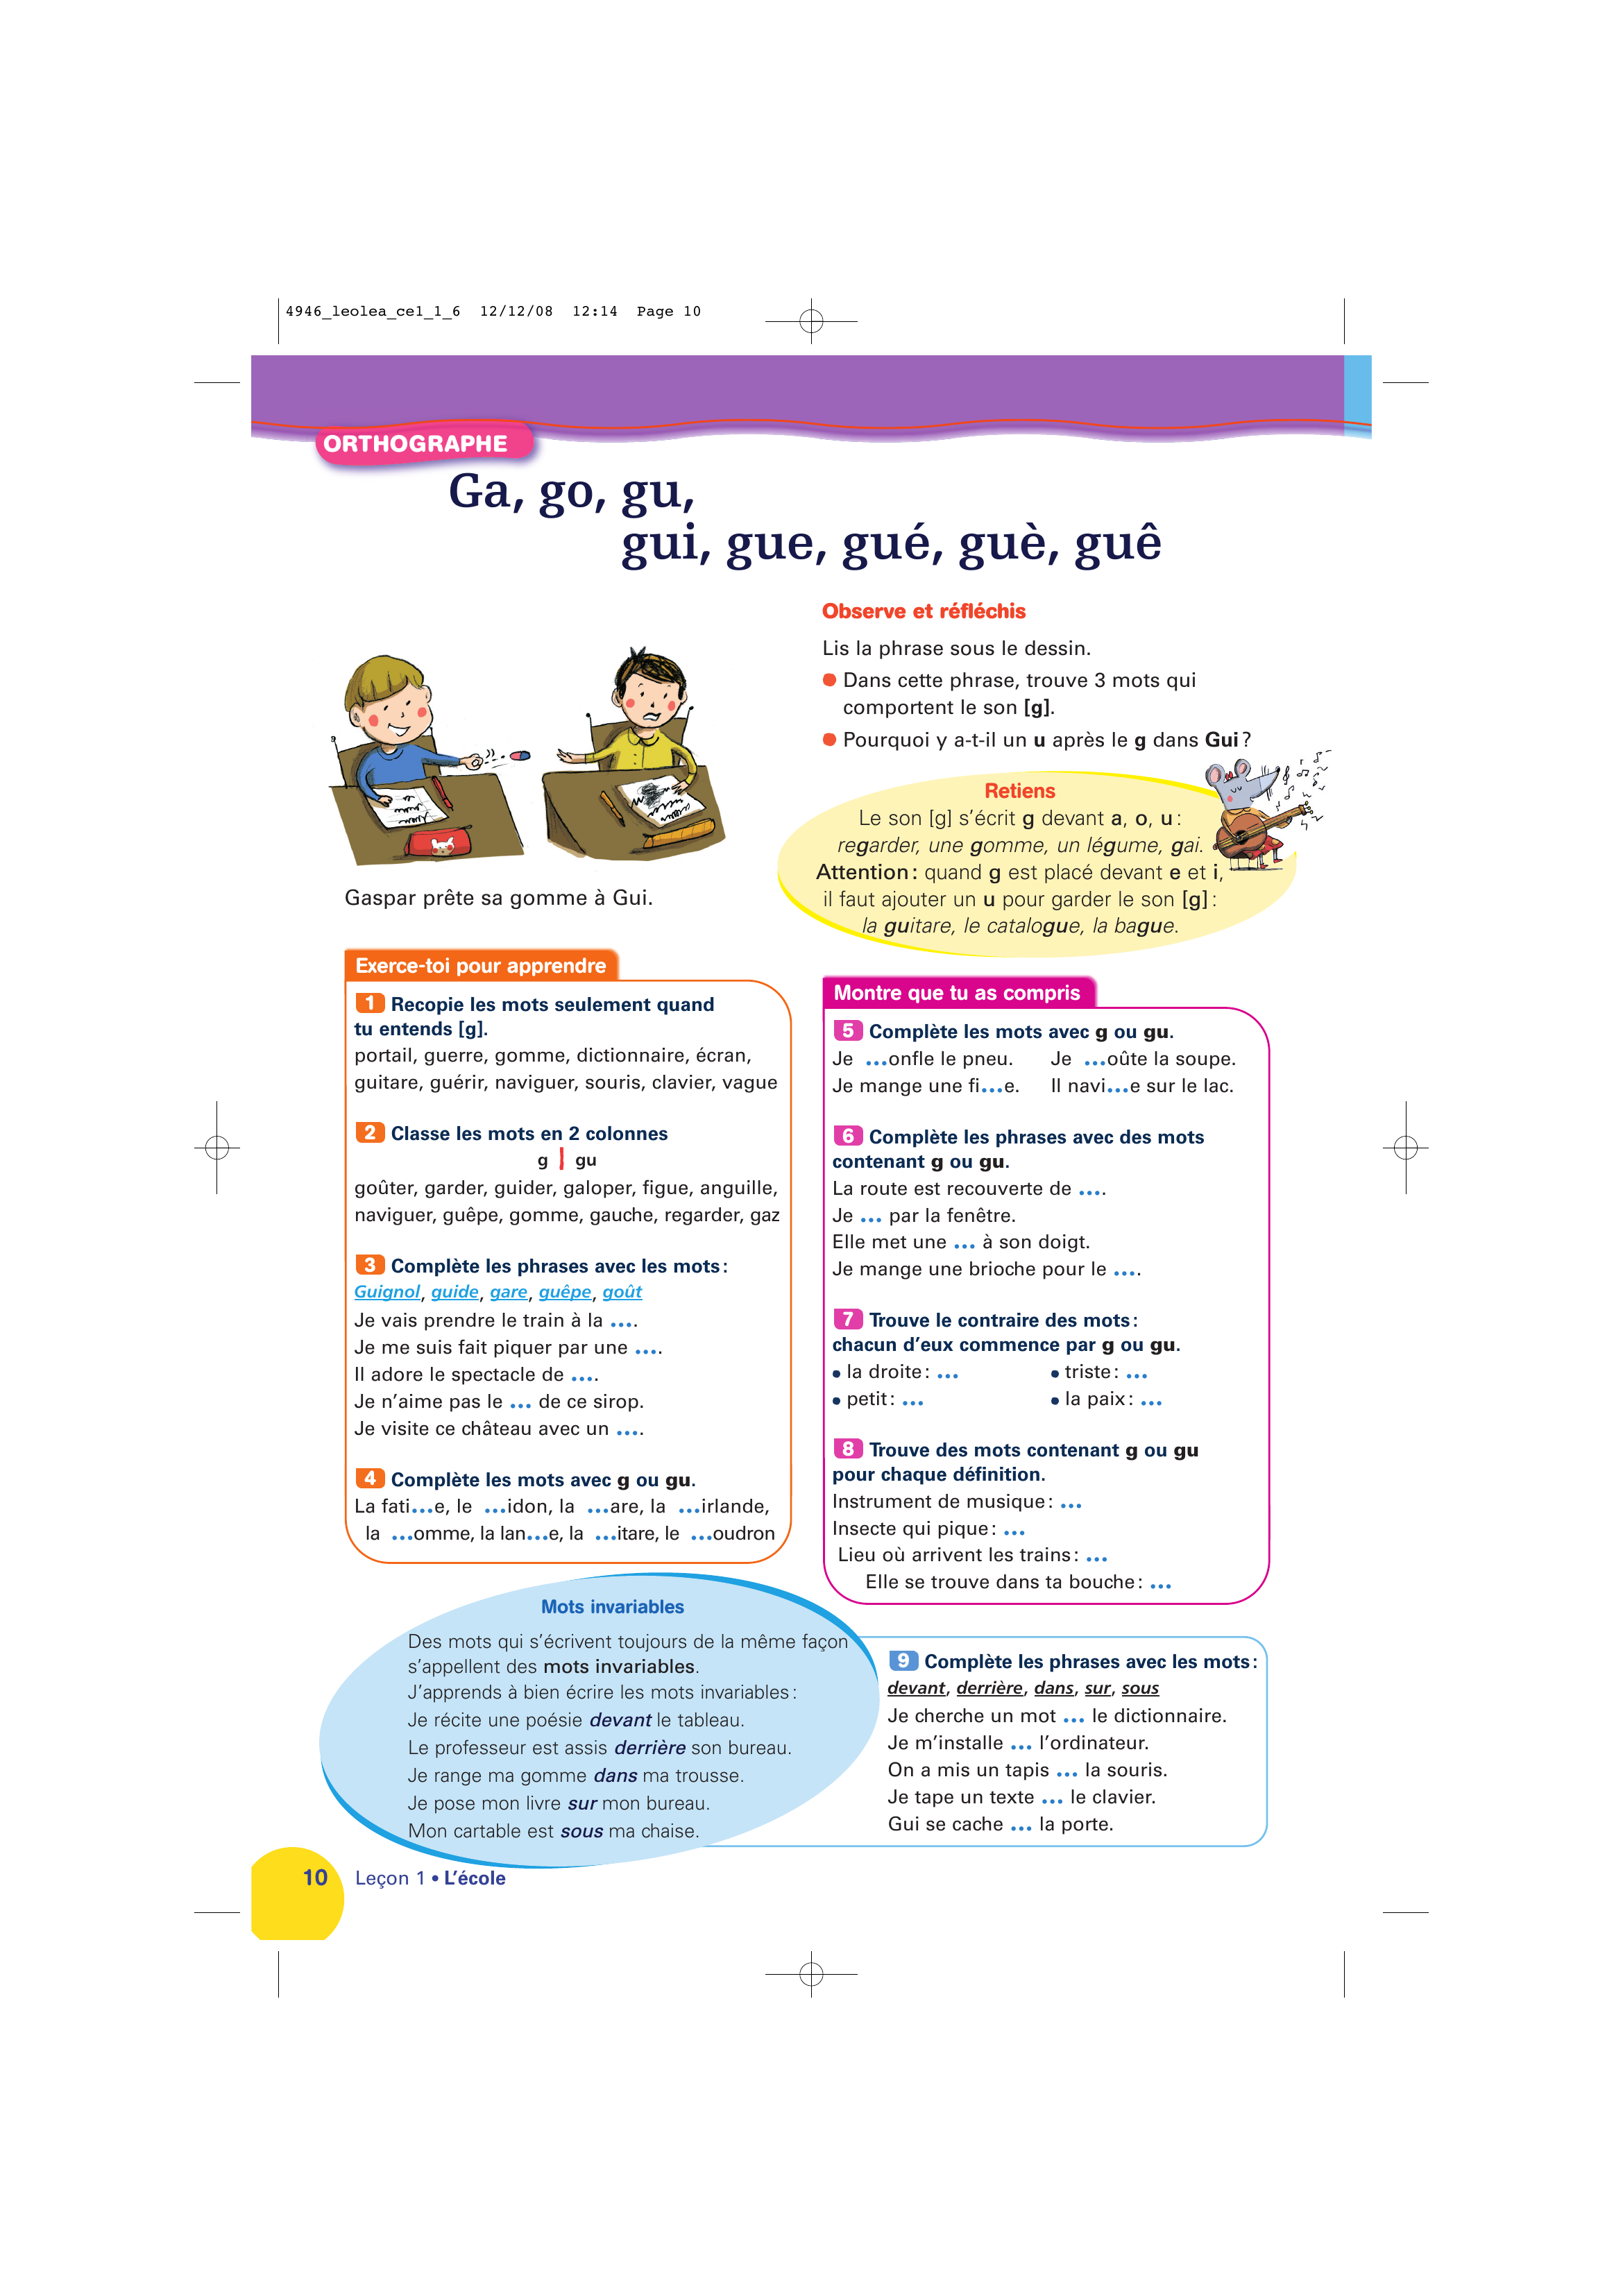

In [7]:
pages[PAGE_NUMBER]

In [8]:
page = list(PDFPage.get_pages(document))[PAGE_NUMBER]
interpreter.process_page(page)
# receive the LTPage object for the page.
layout = device.get_result()
num_lines = [len(element.get_text().split('\n')) for element in layout if isinstance(element, LTTextBoxHorizontal)]
text_content = [element.get_text() for element in layout if isinstance(element, LTTextBoxHorizontal)]
text_content

['4946_leolea_ce1_1_6  12/12/08  12:14  Page 10\n',
 'ORTHOGRAPHE\n',
 'Ga, go, gu,\n',
 'gui, gue, gué, guè, guê\n',
 'Observe et réfléchis\nLis la phrase sous le dessin.\nv Dans cette phrase, trouve 3 mots qui\n',
 'comportent le son [g].\n',
 'v Pourquoi y a-t-il un u après le g dans Gui ?\n',
 'Retiens\n',
 'Le son [g] s’écrit g devant a, o, u :\n',
 'regarder, une gomme, un légume, gai.\n',
 'Attention : quand g est placé devant e et i, \nil faut ajouter un u pour garder le son [g] : \n',
 'la guitare, le catalogue, la bague.\n',
 'Montre que tu as compris\n',
 'Complète les mots avec g ou gu.\n',
 '5\nJe …onfle le pneu.\nJe mange une fi…e.\n',
 'Je …oûte la soupe.\nIl navi…e sur le lac.\n',
 'Complète les phrases avec des mots\n',
 '6\ncontenant g ou gu.\nLa route est recouverte de ….\nJe … par la fenêtre.\nElle met une … à son doigt.\nJe mange une brioche pour le ….\n',
 'Trouve le contraire des mots :\n',
 '7\nchacun d’eux commence par g ou gu.\nv la droite : …\nv petit : …\n',

In [9]:
page = list(PDFPage.get_pages(document))[PAGE_NUMBER]
interpreter.process_page(page)
# receive the LTPage object for the page.
layout = device.get_result()

# Get the text content, only if the y position is < 600 (only for the questions)
num_lines = [len(element.get_text().split('\n')) for element in layout if isinstance(element, LTTextBoxHorizontal) and element.bbox[1] < 600]
text_content = [element.get_text() for element in layout if isinstance(element, LTTextBoxHorizontal) and element.bbox[1] < 600]
# Page is generally the last field
page = text_content[-1].rstrip()
text_content = text_content[:-2]

# Merging the questions into one list element
for i, text in enumerate(text_content):
    if not text.split('\n')[0].isdigit():
        if i != len(text_content)-1 and text_content[i+1].split('\n')[0].isdigit():
            text_content[i+1] = text_content[i+1].split('\n')[0] + '\n' + text + "\n".join(text_content[i+1].split('\n')[1:])
            text_content[i] = ''

for i, text in enumerate(text_content):
    if text.split('\n')[0].isdigit():
        for j, bellow_text in enumerate(text_content[i+1:]):
            if bellow_text.split('\n')[0].isdigit():
                break
            else:
                text_content[i] = text_content[i] + bellow_text

# For some pages, the page appear in the beginning
text_content = [text for text in text_content if text.split('\n')[0].isdigit()]
if 'Page' in text_content[0]:
    first = text_content[0].split()
    page = first[first.index('Page') + 1]
    text_content = text_content[1:]

In [10]:
text_content

['6\nComplète les phrases avec des mots\ncontenant g ou gu.\nLa route est recouverte de ….\nJe … par la fenêtre.\nElle met une … à son doigt.\nJe mange une brioche pour le ….\n',
 '7\nTrouve le contraire des mots :\nchacun d’eux commence par g ou gu.\nv la droite : …\nv petit : …\nv triste : …\nv la paix : …\n',
 '8\nTrouve des mots contenant g ou gu\npour chaque définition.\nInstrument de musique : …\nInsecte qui pique : …\nLieu où arrivent les trains : …\nElle se trouve dans ta bouche : …\n',
 '9\nComplète les phrases avec les mots :\ndevant, derrière, dans, sur, sous\nJe cherche un mot … le dictionnaire.\nJe m’installe … l’ordinateur.\nOn a mis un tapis … la souris.\nJe tape un texte … le clavier.\nGui se cache … la porte.\n',
 '2\nClasse les mots en 2 colonnes\n|\ng\ngu\ngoûter, garder, guider, galoper, figue, anguille,\nnaviguer, guêpe, gomme, gauche, regarder, gaz\n',
 '3\nComplète les phrases avec les mots :\nGuignol, guide, gare, guêpe, goût\nJe vais prendre le train à la ….\nJ

In [32]:
consigne_verbes = ['Trouve', 'Écris', 'Complète', 'Classe', 'Décris', 'Regarde', 'Recopie', 
                  'Associe']

def parse_question(to_parse):
    to_parse = to_parse.split('\n')

    # Cases for choix1 | choix2
    if to_parse[2] == '|':
        tmp = to_parse[:2]
        for i, j in enumerate(to_parse[2:]):
            if len(j) > 4: break
            tmp[-1] = tmp[-1] + ' ' + j
        to_parse = tmp + to_parse[i+2:]
    
    # Getting each part
    num = int(to_parse[0])
    consigne = to_parse[1]
    questions = to_parse[2:]
    
    # In we have two questions
    if (to_parse[2].split(' ')[0] in consigne_verbes) or (to_parse[2][0].islower() and to_parse[2][-1] == '.'):
        consigne = consigne + ' ' + to_parse[2]
        questions = to_parse[3:]
    
    # In case there is two lies of consigne (explication ....)
    if '(' in questions[0]:
        consigne = consigne + questions[0]
        questions = questions[1:]
    
    for i, q in enumerate(questions):
        if len(q) > 0 and q[-1] != '.':
            questions[i] = questions[i] + ' ' + questions[i+1]
            questions[i+1] = ''
    questions = [q.replace('…', '---') for q in questions if len(q) > 0]
    
    if len(questions) == 0:
        return {
        "numéro" : num,
        "consigne" : consigne
        }

    first_line, choix = questions[0].split(' '), ''
    if first_line[0][-1] == ',' and not first_line[0].istitle():
        for j,mot in enumerate(first_line):
            if mot[-1] == ',':
                choix = choix + mot
            else: break
        choix = choix + first_line[j]
            #if not first_line[j+1].istitle(): choix = choix + mot
            #else: break
    
    if len(choix) > 0: 
        choix = [c.strip('.') for c in choix.split(',') if len(c) > 0 and not c.istitle()]
        questions[0] = [m for m in questions[0].split(' ') if m.replace(',', '') not in choix]
        
        if len(questions[0]) > 0 and not questions[0][0].istitle():
            questions[0] = questions[0][1:]
        questions[0] = ' '.join(questions[0])  

    tmp = []
    for q in questions:
        if ' v ' in q :
            q1, q2 = q.split(' v ')            
            tmp.append(q1.strip('v '))
            tmp.append(q2)
        else:
            tmp.append(q)
    questions = tmp

    if len(questions[0]) == 0 and len(choix) > 0:
        questions = choix
        choix = []

    output = {
        "numéro" : num,
        "consigne" : consigne,
        "questions" : questions
    }
    
    if len(choix) > 0: output['choix'] = choix
    return output

In [33]:
questions = [parse_question(i) for i in text_content]
print(json.dumps(questions, indent=2, ensure_ascii=False))

[
  {
    "numéro": 6,
    "consigne": "Complète les phrases avec des mots contenant g ou gu.",
    "questions": [
      "La route est recouverte de ---.",
      "Je --- par la fenêtre.",
      "Elle met une --- à son doigt.",
      "Je mange une brioche pour le ---."
    ]
  },
  {
    "numéro": 7,
    "consigne": "Trouve le contraire des mots : chacun d’eux commence par g ou gu.",
    "questions": [
      "la droite : ---",
      "petit : ---",
      "triste : ---",
      "la paix : ---"
    ]
  },
  {
    "numéro": 8,
    "consigne": "Trouve des mots contenant g ou gu pour chaque définition.",
    "questions": [
      "Instrument de musique : --- Insecte qui pique : ---",
      "Lieu où arrivent les trains : --- Elle se trouve dans ta bouche : ---"
    ]
  },
  {
    "numéro": 9,
    "consigne": "Complète les phrases avec les mots :",
    "questions": [
      "Je cherche un mot --- le dictionnaire.",
      "Je m’installe --- l’ordinateur.",
      "On a mis un tapis --- la souris.",
